# n-step SARSA

In this notebook, we present the implementation of the *n-step SARSA* algorithm, also referred to as *SARSA-TD(n)*, utilizing a neural network to approximate the Q-function. We adhere to the algorithm's specifications, as outlined in Chapter 10.2 of the book Introduction to Reinforcement Learning by Sutton and Barto [1]. The complete pseudocode of the algorithm is depicted in the figure below. We subsequently conduct a series of experiments with varying values of $n$, comparing their outcomes. In the provided implementation, we adopt an experience replay buffer, where each transition stored in the buffer represents an n-step transition.

We use the *CartPole-v1* environment illustrated below, borrowed from the [CartPole Gymnasium webpage](https://gymnasium.farama.org/environments/classic_control/cart_pole/). The goal in the *CartPole-v1* environment is to reach balance a pole on a cart for as long as possible (although we terminate after 200 or so steps). 


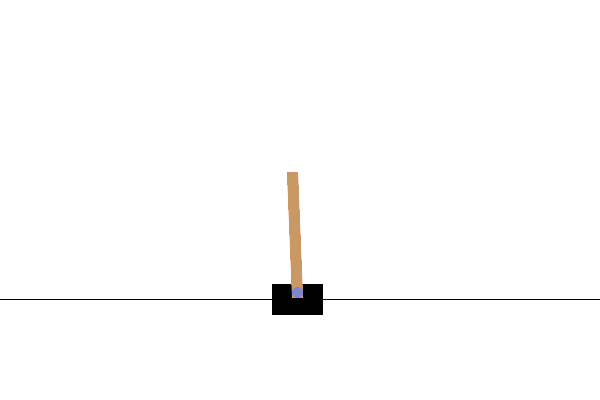


So, let's begin.

In [ ]:
# # uncomment when running on Google Colab
# !pip install -q torch
# !pip install -q gymnasium

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym

Adding a few utility functions for plotting.

In [2]:
def plot_results(avg_scores, std_scores, name=None):
    # set title name
    if name is not None:
        title_name = f"Score averaged over different experiments ({name})"
    else:
        title_name = f"Score averaged over different experiments"
    
    # plot the results from a set of experiments
    n_episodes = len(avg_scores[0])
    n_experiments = len(avg_scores)

    avg_scores = np.array(avg_scores)
    avg_avg_scores = np.mean(avg_scores, axis=0)
    std_avg_scores = np.std(avg_scores, axis=0)
    max_avg_score = np.max(avg_scores, axis=0)
    min_avg_score = np.min(avg_scores, axis=0)

    upper_std_scores = max_avg_score
    lower_std_scores = min_avg_score
    x = range(1, n_episodes + 1)

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(11, 6), sharex=True)
    
    ax[0].set_title(title_name)
    ax[0].plot(x, avg_avg_scores, label=f'average score')
    ax[0].fill_between(x, upper_std_scores, lower_std_scores, 
                    where=(upper_std_scores > lower_std_scores), alpha=0.3)

    for i in range(n_experiments):
        avg_scores_numpy = np.array(avg_scores[i])
        std_scores_numpy = np.array(std_scores[i])
        upper = avg_scores_numpy + std_scores_numpy
        lower = avg_scores_numpy - std_scores_numpy
        ax[1].plot(x, avg_scores_numpy, label=f'Exp-{i}')
        ax[1].fill_between(x, upper, lower, where=(upper > lower), alpha=0.3)

    ax[1].set_xlabel('episode')
    ax[0].set_ylabel('score')
    ax[1].set_ylabel('score')
    ax[0].legend()
    ax[0].grid()
    ax[1].legend()
    ax[1].grid()
    plt.show()
    
def compare_results(data_dict, idx=0):
    """
    Compare the results from different experiments
    :param: data_dict = {name1: [avg_scores1, std_scores1], 
                         name2: [avg_scores2, std_scores2],
                         ...
                         nameN: [avg_scoresN, std_scoresN],}
    """
    
    # plot the results from a set of experiments
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 6))
    ax.set_title("Comparison of different RL algorithms' averaged score over a set of experiments")
    
    for item in data_dict:
        name = item
        avg_scores, std_scores = data_dict[name]
        
        n_episodes = len(avg_scores[0])
        n_experiments = len(avg_scores)

        avg_scores = np.array(avg_scores)
        avg_avg_scores = np.mean(avg_scores, axis=0)
        std_avg_scores = np.std(avg_scores, axis=0)
        max_avg_score = np.max(avg_scores, axis=0)
        min_avg_score = np.min(avg_scores, axis=0)

        upper_std_scores = max_avg_score
        lower_std_scores = min_avg_score
        x = range(1, n_episodes + 1)


        ax.plot(x[idx:], avg_avg_scores[idx:], label=f'{name} agent')
        ax.fill_between(x[idx:], upper_std_scores[idx:], lower_std_scores[idx:], 
                        where=(upper_std_scores[idx:] > lower_std_scores[idx:]), alpha=0.3)


    ax.set_ylabel('score')
    ax.legend()
    ax.grid()
    plt.show()

# n-step SARSA

Below is the complete *n-step SARSA* with Q-function approximation (in our case, using a neural network) taken from [1].

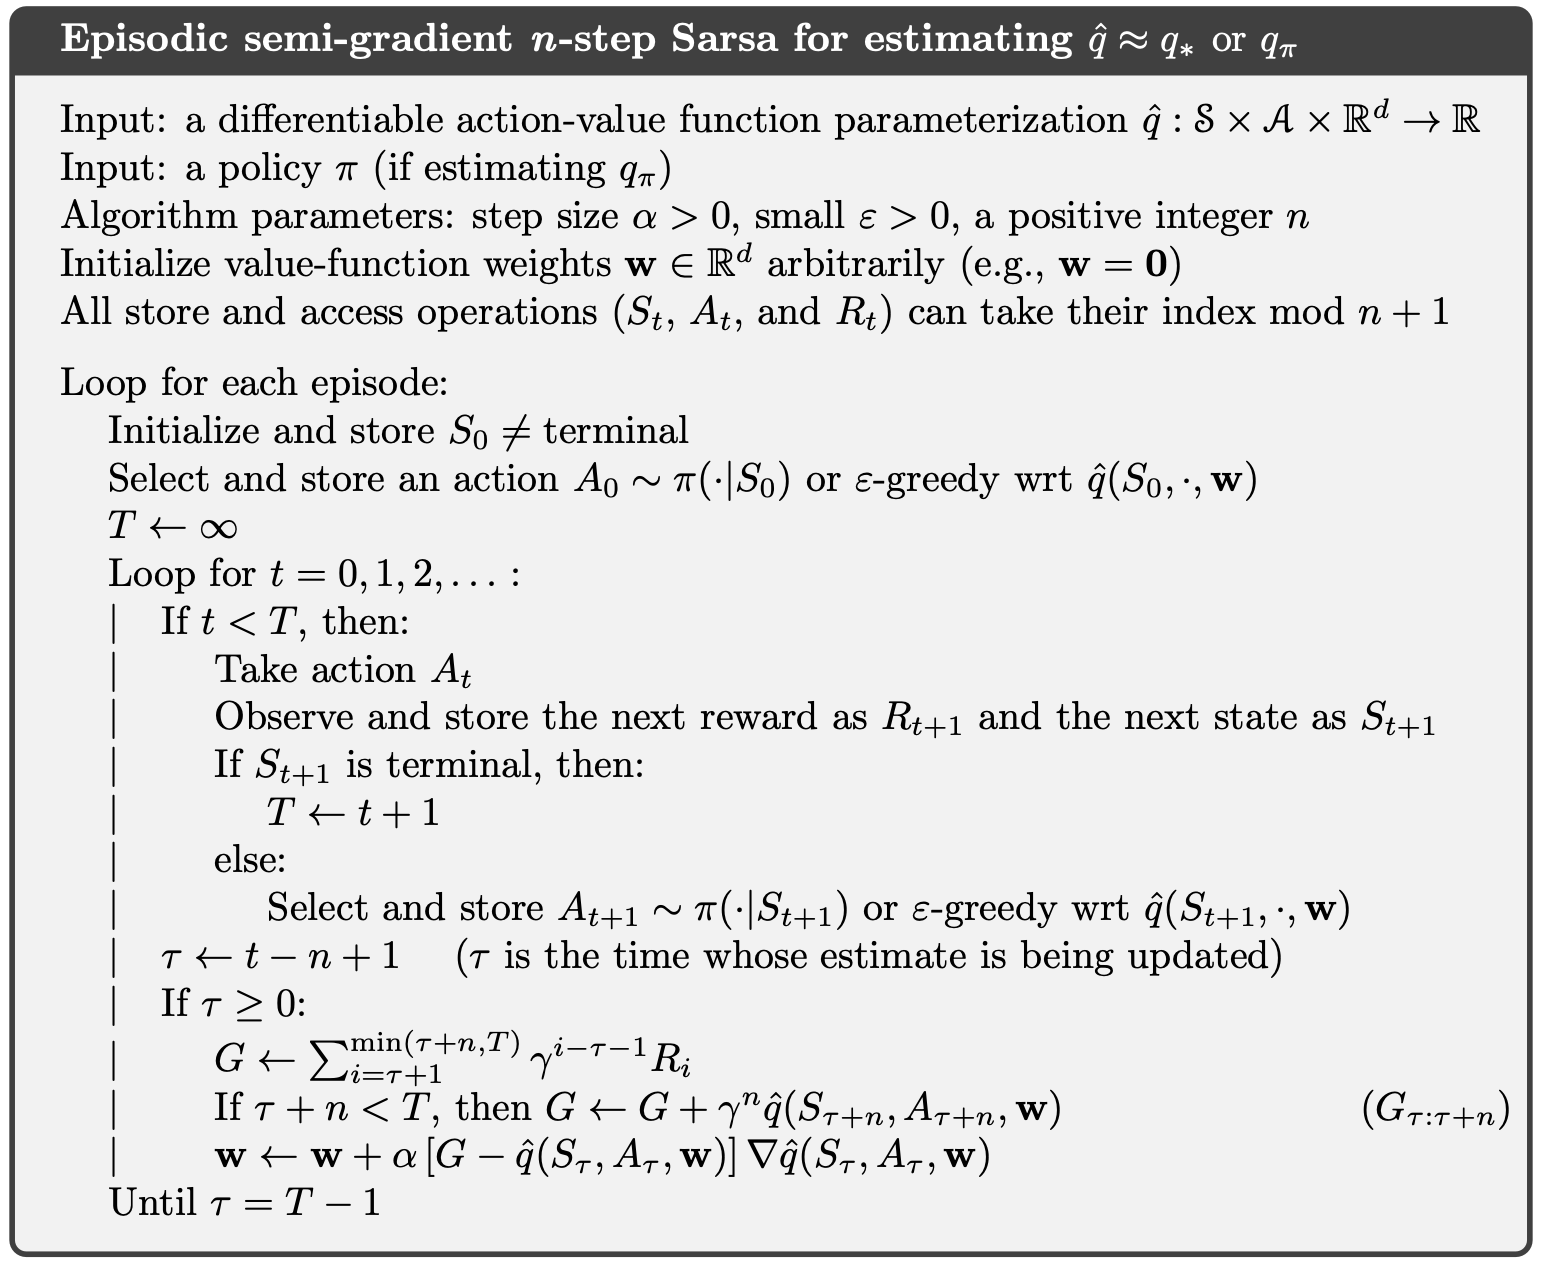

First, we code the Q-network.

In [3]:
class QNetwork(nn.Module):
    def __init__(self, observation_dim, action_dim, learning_rate):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(in_features=observation_dim, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=256)
        self.output_layer = nn.Linear(in_features=256, out_features=action_dim)

        self.optimizer = T.optim.Adam(params=self.parameters(), lr=learning_rate)
        self.device = ("cuda:0" if T.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.output_layer(x)
        return x

Then, we code the n-step memory, that saves n-step transitions. Notice that the memory for a value of $n$ is $n+1$ long.

In [4]:
class NStepMemory:
    def __init__(self, n, observation_dim):
        self.observation_dim = observation_dim
        self.n = n
        self.is_full = False
        self.ptr = 0

        self.observations = None
        self.actions = None
        self.rewards = None
        self.terminates = None

    def reset(self):
        self.observations = np.zeros((self.n + 1, self.observation_dim), dtype=np.float32)
        self.actions = np.zeros((self.n + 1, 1), dtype=int)
        self.rewards = np.zeros((self.n + 1, 1), dtype=np.float32)
        self.terminates = np.zeros((self.n + 1, 1), dtype=bool)
        self.ptr = 0

    def store_transition(self, reward, terminated, observation, action):
        self.observations[self.ptr] = observation
        self.actions[self.ptr] = action
        self.rewards[self.ptr] = reward
        self.terminates[self.ptr] = terminated

        self.ptr = (self.ptr + 1) % (self.n + 1)
        if self.ptr == 0 and not self.is_full:
            self.is_full = True
            print("memory is full...")

    def load_trajectory(self):
        assert self.is_full, "The memory is not full, wait until it will be full before loading a trajectory."
        observations = np.concatenate((self.observations[self.ptr:], self.observations[:self.ptr]))
        actions = np.concatenate((self.actions[self.ptr:], self.actions[:self.ptr]))
        rewards = np.concatenate((self.rewards[self.ptr:], self.rewards[:self.ptr]))
        terminates = np.concatenate((self.terminates[self.ptr:], self.terminates[:self.ptr]))
        return observations, actions, rewards, terminates


Next, we code the replay buffer for n0step transitions.

In [5]:
class ReplayBuffer:
    def __init__(self, memory_size, observation_dim, n):
        self.observation_dim = observation_dim
        self.memory_size = memory_size
        self.n = n
        self.ptr = 0
        self.is_full = False

        self.observations = None
        self.actions = None
        self.rewards = None
        self.terminates = None

    def reset(self):
        print("reset buffer...")
        self.observations = np.zeros((self.memory_size, self.n + 1, self.observation_dim), dtype=np.float32)
        self.actions = np.zeros((self.memory_size, self.n + 1, 1), dtype=int)
        self.rewards = np.zeros((self.memory_size, self.n + 1, 1), dtype=np.float32)
        self.terminates = np.zeros((self.memory_size, self.n + 1, 1), dtype=bool)
        self.ptr = 0

    def store_transition(self, observations, actions, rewards, terminates):
        self.observations[self.ptr] = observations
        self.actions[self.ptr] = actions
        self.rewards[self.ptr] = rewards
        self.terminates[self.ptr] = terminates

        self.ptr = (self.ptr + 1) % self.memory_size
        if self.ptr == 0 and not self.is_full:
            self.is_full = True
            print("buffer is full...")

    def load_transition(self, batch_size=1):
        upper = self.memory_size if self.is_full else self.ptr
        samples = np.random.choice(upper, size=batch_size)
        return self.observations[samples], self.actions[samples], self.rewards[samples], self.terminates[samples]


Presently, we proceed to construct the SARSA agent. It should be noted that within the `learn` function, we execute a `detach` operation on the `next_q_values` variable, which denotes the estimation of the q-value for the return at the terminal element in the n-step transition. This action is undertaken as the `next_q_values` variable constitutes an element of the target and thus should be devoid of gradients. Consequently, solely the gradients of the network's parameters with respect to the q-values at the commencement of the transition are sought.

In [6]:
class NStepSarsaAgentWithBuffer:
    def __init__(self, observation_dim, n_actions, learning_rate, gamma, epsilon, epsilon_dec,
                 epsilon_min, n, memory_size):
        self.observation_dim = observation_dim
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.n_actions = n_actions
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_min = epsilon_min
        self.n = n
        self.memory_size = memory_size

        # initialize a Q-network
        self.q = QNetwork(observation_dim=observation_dim, action_dim=n_actions, learning_rate=learning_rate)

        # initialize an n-step memory
        self.memory = NStepMemory(n=self.n, observation_dim=self.observation_dim)

        # initialize a replay buffer
        self.replay_buffer = ReplayBuffer(memory_size=self.memory_size, observation_dim=self.observation_dim, n=self.n)
        self.replay_buffer.reset()
    
    def full_reset(self):
        print("agent full reset...")
        self.memory.reset()
        self.replay_buffer.reset()
        self.q = QNetwork(observation_dim=self.observation_dim, action_dim=self.n_actions, 
                          learning_rate=self.learning_rate)

    def reset(self):
        self.tau = 0
        self.memory.reset()

    def choose_action(self, observation):
        observation = T.Tensor(observation).float().to(self.q.device)
        if np.random.rand() < self.epsilon:
            action = np.random.randint(self.n_actions)
        else:
            q_values = self.q(observation)
            action = T.argmax(q_values).item()
        return action

    def decrement_epsilon(self):
        self.epsilon = np.max([self.epsilon - self.epsilon_dec, self.epsilon_min])

    def value_estimate(self, observation, action):
        observation = T.Tensor(observation).float().to(self.q.device)
        action = T.Tensor([action]).int().view(-1).to(self.q.device)
        q_value = self.q(observation)[action]
        return q_value

    def store_transition(self, reward, terminated, observation, action):
        self.memory.store_transition(reward, terminated, observation, action)
        if self.memory.is_full:
            observations, actions, rewards, terminates = self.memory.load_trajectory()
            self.replay_buffer.store_transition(observations, actions, rewards, terminates)

    def load_transition(self, batch_size=1):
        return self.replay_buffer.load_transition(batch_size=batch_size)

    def learn(self, batch_size=1):
        if not self.replay_buffer.is_full and self.replay_buffer.ptr <= batch_size:
            return
        # load n-step trajectory
        observations, actions, rewards, terminates = self.load_transition(batch_size=batch_size)

        # send trajectory to device
        observations = T.Tensor(observations).float().to(self.q.device)         # (batch_size, n, observation_dim)
        actions = T.Tensor(actions).int().squeeze().to(self.q.device)           # (batch_size, n)
        rewards = T.Tensor(rewards).float().squeeze().to(self.q.device)         # (batch_size, n)
        terminates = T.Tensor(terminates).bool().squeeze().to(self.q.device)    # (batch_size, n)

        # compute the return
        indices = T.arange(batch_size).to(self.q.device)
        gammas = T.pow(self.gamma * T.ones(self.n), T.arange(self.n)).to(self.q.device)
        target = T.tensordot(rewards[:, 1:], gammas, dims=([1], [0]))
        next_q_values = self.q(observations[:, -1])[indices, actions[:, -1]].detach()
        next_q_values[terminates[:, -1]] = 0.0
        target = target + np.power(self.gamma, self.n) * next_q_values

        q_value = self.q(observations[:, 0])[indices, actions[:, 0]]

        # train the network
        self.q.optimizer.zero_grad()
        loss = F.mse_loss(q_value, target)
        loss.backward()
        self.q.optimizer.step()

        # decrement epsilon
        self.decrement_epsilon()


In order to make things a bit easier on the eyes, we code the experiment loop as a function. 

In [7]:
def run_loop(env_name, agent, n_experiments, n_episodes, max_steps):
    
    scores = []
    avg_scores = []
    std_scores = []
    
    # experiments loop
    for ex_i in range(n_experiments):
        scores.append([])
        avg_scores.append([])
        std_scores.append([])
        
        # reset the agent completely for each experiment
        env = gym.make(env_name)
        agent.full_reset()
        
        # episodes loop
        for ep_i in range(n_episodes):
            score = 0
            done = False
            step = 0
            
            # reset the env and the agent
            agent.reset()
            observation, info = env.reset()
            action = agent.choose_action(observation)

            # store state and action
            agent.store_transition(0.0, False, observation, action)
            
            # a single episode loop
            while not done:
                
                # step the environment
                next_observation, reward, terminated, truncated, info = env.step(action)
                score += reward

                # select the next action
                next_action = agent.choose_action(next_observation)

                # store the SARSA transition
                agent.store_transition(reward, terminated, next_observation, next_action)
                action = next_action

                # check for termination
                if terminated or truncated or step == max_steps:
                    done = True
                    scores[ex_i].append(score)
                    avg_scores[ex_i].append(np.mean(scores[ex_i][-100:]))
                    std_scores[ex_i].append(np.std(scores[ex_i][-100:]))
                
                # train the agent
                agent.learn(batch_size=BATCH_SIZE)
                step += 1
                
            # print results status
            if ep_i % 10 == 0:
                print(f'| Experiment: {ex_i + 1:4} | Episode: {ep_i:4} | Score: {np.round(score, 2):4.1f} |' +
                      f' Avg score: {np.round(avg_scores[ex_i][-1], 2):4.1f} |')
        env.close()    
    return avg_scores, std_scores

Finally, we run a few experiments with identical hyperparameters and different $n$ values, and compare their results.

In [61]:
# make the environment
env_name = "CartPole-v1"
env = gym.make(env_name)

# set experiment results dictionary
results_data_dict = {}

# set the hyperparameters for the agent
N_EXPERIMENTS = 5
N_EPISODES = 400
MAX_STEPS = 200
GAMMA = 0.99
LR = 0.001
EPSILON = 1.
EPSILON_MIN = 0.001
EPSILON_DEC = (EPSILON - EPSILON_MIN) / (N_EPISODES * 0.2)
OBSERVATION_DIM = env.observation_space.shape[0]
N_ACTIONS = env.action_space.n
ACTION_DIM = 1
MEMORY_SIZE = 100000
BATCH_SIZE = 8


# set the number of steps to use in the n-steps algorithm
n_list = [1, 2, 4, 8, 16]

# run experiments for different n-step values
for n in n_list:
    print(f"\nInitialize a new experiment of n-step SARSA with n = {str(n)}...")
    
    # initialize the agent
    agent = NStepSarsaAgentWithBuffer(observation_dim=OBSERVATION_DIM, 
                                      n_actions=N_ACTIONS,
                                      learning_rate=LR, 
                                      gamma=GAMMA, 
                                      epsilon=EPSILON, 
                                      epsilon_dec=EPSILON_DEC,
                                      epsilon_min=EPSILON_MIN,  
                                      memory_size=MEMORY_SIZE,
                                      n=n)

    # run single experiment
    avg_scores, std_scores = run_loop(env_name=env_name, 
                                      agent=agent, 
                                      n_experiments=N_EXPERIMENTS, 
                                      n_episodes=N_EPISODES, 
                                      max_steps=MAX_STEPS)

    # save experiment's data for later comparison
    results_data_dict[f"n = {str(n)}"] = avg_scores, std_scores


Initialize a new experiment of n-step SARSA with n = 1...
reset buffer...
agent full reset...
reset buffer...
memory is full...
| Experiment:    1 | Episode:    0 | Score: 21.000 | Avg score: 21.000 |
| Experiment:    1 | Episode:   10 | Score: 9.000 | Avg score: 11.550 |
| Experiment:    1 | Episode:   20 | Score: 21.000 | Avg score: 15.860 |
| Experiment:    1 | Episode:   30 | Score: 65.000 | Avg score: 28.970 |
| Experiment:    1 | Episode:   40 | Score: 51.000 | Avg score: 36.050 |
| Experiment:    1 | Episode:   50 | Score: 77.000 | Avg score: 41.840 |
| Experiment:    1 | Episode:   60 | Score: 201.000 | Avg score: 60.360 |
| Experiment:    1 | Episode:   70 | Score: 201.000 | Avg score: 77.580 |
| Experiment:    1 | Episode:   80 | Score: 201.000 | Avg score: 92.650 |
| Experiment:    1 | Episode:   90 | Score: 201.000 | Avg score: 104.560 |
| Experiment:    1 | Episode:  100 | Score: 201.000 | Avg score: 115.040 |
| Experiment:    1 | Episode:  110 | Score: 201.000 | Avg scor

| Experiment:    3 | Episode:  280 | Score: 201.000 | Avg score: 201.000 |
| Experiment:    3 | Episode:  290 | Score: 201.000 | Avg score: 201.000 |
| Experiment:    3 | Episode:  300 | Score: 201.000 | Avg score: 201.000 |
| Experiment:    3 | Episode:  310 | Score: 201.000 | Avg score: 201.000 |
| Experiment:    3 | Episode:  320 | Score: 201.000 | Avg score: 201.000 |
| Experiment:    3 | Episode:  330 | Score: 201.000 | Avg score: 200.720 |
| Experiment:    3 | Episode:  340 | Score: 201.000 | Avg score: 200.720 |
| Experiment:    3 | Episode:  350 | Score: 201.000 | Avg score: 200.680 |
| Experiment:    3 | Episode:  360 | Score: 201.000 | Avg score: 200.680 |
| Experiment:    3 | Episode:  370 | Score: 201.000 | Avg score: 200.680 |
| Experiment:    3 | Episode:  380 | Score: 201.000 | Avg score: 200.680 |
| Experiment:    3 | Episode:  390 | Score: 201.000 | Avg score: 200.680 |
agent full reset...
reset buffer...
| Experiment:    4 | Episode:    0 | Score: 21.000 | Avg score: 

| Experiment:    1 | Episode:  160 | Score: 183.000 | Avg score: 90.480 |
| Experiment:    1 | Episode:  170 | Score: 201.000 | Avg score: 104.040 |
| Experiment:    1 | Episode:  180 | Score: 201.000 | Avg score: 116.380 |
| Experiment:    1 | Episode:  190 | Score: 201.000 | Avg score: 133.460 |
| Experiment:    1 | Episode:  200 | Score: 112.000 | Avg score: 151.300 |
| Experiment:    1 | Episode:  210 | Score: 201.000 | Avg score: 170.420 |
| Experiment:    1 | Episode:  220 | Score: 201.000 | Avg score: 184.420 |
| Experiment:    1 | Episode:  230 | Score: 201.000 | Avg score: 185.810 |
| Experiment:    1 | Episode:  240 | Score: 201.000 | Avg score: 188.270 |
| Experiment:    1 | Episode:  250 | Score: 201.000 | Avg score: 193.010 |
| Experiment:    1 | Episode:  260 | Score: 201.000 | Avg score: 194.930 |
| Experiment:    1 | Episode:  270 | Score: 201.000 | Avg score: 196.720 |
| Experiment:    1 | Episode:  280 | Score: 201.000 | Avg score: 197.160 |
| Experiment:    1 | Episo

| Experiment:    4 | Episode:   50 | Score: 39.000 | Avg score: 25.220 |
| Experiment:    4 | Episode:   60 | Score: 126.000 | Avg score: 33.890 |
| Experiment:    4 | Episode:   70 | Score: 106.000 | Avg score: 45.720 |
| Experiment:    4 | Episode:   80 | Score: 168.000 | Avg score: 56.800 |
| Experiment:    4 | Episode:   90 | Score: 160.000 | Avg score: 69.630 |
| Experiment:    4 | Episode:  100 | Score: 201.000 | Avg score: 82.790 |
| Experiment:    4 | Episode:  110 | Score: 201.000 | Avg score: 101.490 |
| Experiment:    4 | Episode:  120 | Score: 201.000 | Avg score: 119.240 |
| Experiment:    4 | Episode:  130 | Score: 201.000 | Avg score: 137.110 |
| Experiment:    4 | Episode:  140 | Score: 201.000 | Avg score: 153.810 |
| Experiment:    4 | Episode:  150 | Score: 201.000 | Avg score: 169.140 |
| Experiment:    4 | Episode:  160 | Score: 201.000 | Avg score: 181.430 |
| Experiment:    4 | Episode:  170 | Score: 201.000 | Avg score: 189.740 |
| Experiment:    4 | Episode:  1

| Experiment:    1 | Episode:  340 | Score: 163.000 | Avg score: 179.840 |
| Experiment:    1 | Episode:  350 | Score: 201.000 | Avg score: 184.240 |
| Experiment:    1 | Episode:  360 | Score: 201.000 | Avg score: 188.610 |
| Experiment:    1 | Episode:  370 | Score: 201.000 | Avg score: 190.740 |
| Experiment:    1 | Episode:  380 | Score: 201.000 | Avg score: 193.050 |
| Experiment:    1 | Episode:  390 | Score: 201.000 | Avg score: 194.820 |
agent full reset...
reset buffer...
| Experiment:    2 | Episode:    0 | Score: 10.000 | Avg score: 10.000 |
| Experiment:    2 | Episode:   10 | Score: 10.000 | Avg score: 9.550 |
| Experiment:    2 | Episode:   20 | Score: 9.000 | Avg score: 9.570 |
| Experiment:    2 | Episode:   30 | Score: 9.000 | Avg score: 9.610 |
| Experiment:    2 | Episode:   40 | Score: 9.000 | Avg score: 9.560 |
| Experiment:    2 | Episode:   50 | Score: 9.000 | Avg score: 9.530 |
| Experiment:    2 | Episode:   60 | Score: 10.000 | Avg score: 9.520 |
| Experiment:

| Experiment:    4 | Episode:  260 | Score: 201.000 | Avg score: 120.490 |
| Experiment:    4 | Episode:  270 | Score: 201.000 | Avg score: 134.680 |
| Experiment:    4 | Episode:  280 | Score: 201.000 | Avg score: 141.100 |
| Experiment:    4 | Episode:  290 | Score: 201.000 | Avg score: 150.900 |
| Experiment:    4 | Episode:  300 | Score: 201.000 | Avg score: 163.280 |
| Experiment:    4 | Episode:  310 | Score: 201.000 | Avg score: 176.780 |
| Experiment:    4 | Episode:  320 | Score: 201.000 | Avg score: 188.440 |
| Experiment:    4 | Episode:  330 | Score: 201.000 | Avg score: 198.960 |
| Experiment:    4 | Episode:  340 | Score: 201.000 | Avg score: 200.650 |
| Experiment:    4 | Episode:  350 | Score: 201.000 | Avg score: 200.650 |
| Experiment:    4 | Episode:  360 | Score: 201.000 | Avg score: 200.650 |
| Experiment:    4 | Episode:  370 | Score: 201.000 | Avg score: 200.650 |
| Experiment:    4 | Episode:  380 | Score: 201.000 | Avg score: 201.000 |
| Experiment:    4 | Epis

| Experiment:    2 | Episode:  170 | Score: 24.000 | Avg score: 14.850 |
| Experiment:    2 | Episode:  180 | Score: 25.000 | Avg score: 16.630 |
| Experiment:    2 | Episode:  190 | Score: 30.000 | Avg score: 17.880 |
| Experiment:    2 | Episode:  200 | Score: 23.000 | Avg score: 19.510 |
| Experiment:    2 | Episode:  210 | Score: 25.000 | Avg score: 19.750 |
| Experiment:    2 | Episode:  220 | Score: 44.000 | Avg score: 21.790 |
| Experiment:    2 | Episode:  230 | Score: 48.000 | Avg score: 24.840 |
| Experiment:    2 | Episode:  240 | Score: 35.000 | Avg score: 28.090 |
| Experiment:    2 | Episode:  250 | Score: 19.000 | Avg score: 30.760 |
| Experiment:    2 | Episode:  260 | Score: 16.000 | Avg score: 29.820 |
| Experiment:    2 | Episode:  270 | Score: 10.000 | Avg score: 28.290 |
| Experiment:    2 | Episode:  280 | Score: 10.000 | Avg score: 26.520 |
| Experiment:    2 | Episode:  290 | Score: 9.000 | Avg score: 25.260 |
| Experiment:    2 | Episode:  300 | Score: 8.000 | 

| Experiment:    5 | Episode:  120 | Score: 9.000 | Avg score: 9.910 |
| Experiment:    5 | Episode:  130 | Score: 9.000 | Avg score: 9.650 |
| Experiment:    5 | Episode:  140 | Score: 10.000 | Avg score: 9.360 |
| Experiment:    5 | Episode:  150 | Score: 8.000 | Avg score: 9.330 |
| Experiment:    5 | Episode:  160 | Score: 9.000 | Avg score: 9.330 |
| Experiment:    5 | Episode:  170 | Score: 10.000 | Avg score: 9.500 |
| Experiment:    5 | Episode:  180 | Score: 25.000 | Avg score: 12.510 |
| Experiment:    5 | Episode:  190 | Score: 20.000 | Avg score: 13.360 |
| Experiment:    5 | Episode:  200 | Score: 29.000 | Avg score: 14.690 |
| Experiment:    5 | Episode:  210 | Score: 22.000 | Avg score: 16.430 |
| Experiment:    5 | Episode:  220 | Score: 27.000 | Avg score: 17.920 |
| Experiment:    5 | Episode:  230 | Score: 25.000 | Avg score: 19.350 |
| Experiment:    5 | Episode:  240 | Score: 49.000 | Avg score: 21.460 |
| Experiment:    5 | Episode:  250 | Score: 38.000 | Avg scor

| Experiment:    3 | Episode:   40 | Score: 9.000 | Avg score: 9.320 |
| Experiment:    3 | Episode:   50 | Score: 9.000 | Avg score: 9.330 |
| Experiment:    3 | Episode:   60 | Score: 10.000 | Avg score: 9.380 |
| Experiment:    3 | Episode:   70 | Score: 9.000 | Avg score: 9.390 |
| Experiment:    3 | Episode:   80 | Score: 9.000 | Avg score: 9.360 |
| Experiment:    3 | Episode:   90 | Score: 9.000 | Avg score: 9.350 |
| Experiment:    3 | Episode:  100 | Score: 10.000 | Avg score: 9.370 |
| Experiment:    3 | Episode:  110 | Score: 9.000 | Avg score: 9.360 |
| Experiment:    3 | Episode:  120 | Score: 10.000 | Avg score: 9.370 |
| Experiment:    3 | Episode:  130 | Score: 10.000 | Avg score: 9.370 |
| Experiment:    3 | Episode:  140 | Score: 9.000 | Avg score: 9.390 |
| Experiment:    3 | Episode:  150 | Score: 10.000 | Avg score: 9.370 |
| Experiment:    3 | Episode:  160 | Score: 9.000 | Avg score: 9.360 |
| Experiment:    3 | Episode:  170 | Score: 9.000 | Avg score: 9.360 |
|

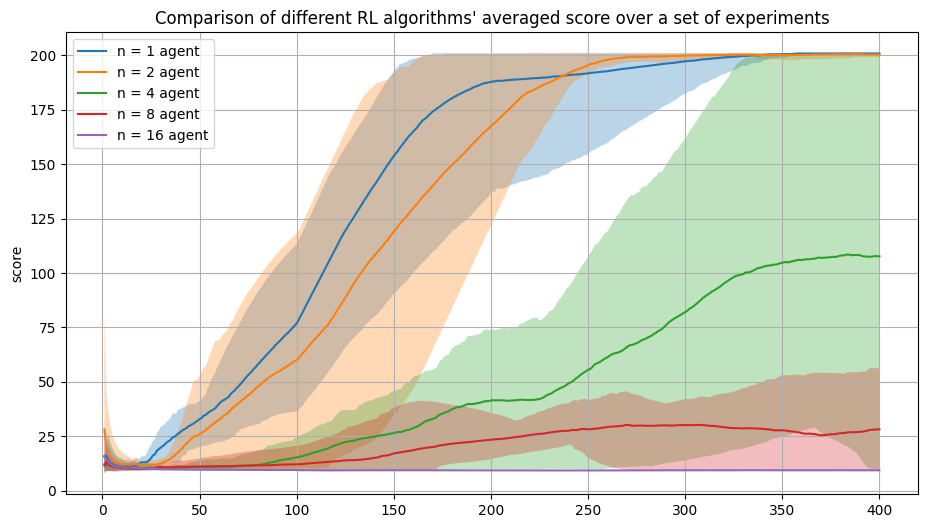

In [62]:
compare_results(results_data_dict, idx=0)

It can be observed that larger values of $n$ present increased training difficulty. Nonetheless, it must be borne in mind that we select the optimal learning rate specifically for $n=1$. Therefore, it is not unexpected that the best outcomes arise for this configuration. As per Chapter 10.2 in [1], distinct values of $n$ correspond to unique optimal learning rate values. Hence, we shall endeavor to vary the learning rate and assess the outcomes.

In [9]:
# make the environment
env_name = "CartPole-v1"
env = gym.make(env_name)

# set the hyperparameters for the agent
N_EXPERIMENTS = 5
N_EPISODES = 200
MAX_STEPS = 300
GAMMA = 0.99
EPSILON = 1.
EPSILON_MIN = 0.001
EPSILON_DEC = (EPSILON - EPSILON_MIN) / (N_EPISODES * 0.2)
OBSERVATION_DIM = env.observation_space.shape[0]
N_ACTIONS = env.action_space.n
ACTION_DIM = 1
MEMORY_SIZE = 100000
BATCH_SIZE = 8


# set the number of steps to use in the n-steps algorithm
n_list = [1, 2, 4, 8, 16]

# set the learning rate
lr_list = np.logspace(-2, -7, num=14, base=10)

# set experiments results array
final_results = np.zeros((len(lr_list), len(n_list)))
results_data_dict = {}


# run experiments for different n-step values
for i, lr in enumerate(lr_list):
    for j, n in enumerate(n_list):
        print(f"\nInitialize a new experiment of n-step SARSA with n = {str(n)} and lr = {str(lr)}...")

        # initialize the agent
        agent = NStepSarsaAgentWithBuffer(observation_dim=OBSERVATION_DIM, 
                                          n_actions=N_ACTIONS,
                                          learning_rate=lr, 
                                          gamma=GAMMA, 
                                          epsilon=EPSILON, 
                                          epsilon_dec=EPSILON_DEC,
                                          epsilon_min=EPSILON_MIN,  
                                          memory_size=MEMORY_SIZE,
                                          n=n)

        # run single experiment
        avg_scores, std_scores = run_loop(env_name=env_name, 
                                          agent=agent, 
                                          n_experiments=N_EXPERIMENTS, 
                                          n_episodes=N_EPISODES, 
                                          max_steps=MAX_STEPS)

        # save experiment's data for later comparison
        results_data_dict[(i, j)] = avg_scores, std_scores
        final_results[i, j] = np.max(avg_scores)


Initialize a new experiment of n-step SARSA with n = 1 and lr = 0.01...
reset buffer...
agent full reset...
reset buffer...
memory is full...
| Experiment:    1 | Episode:    0 | Score: 12.0 | Avg score: 12.0 |
| Experiment:    1 | Episode:   10 | Score: 32.0 | Avg score: 13.9 |
| Experiment:    1 | Episode:   20 | Score: 41.0 | Avg score: 15.5 |
| Experiment:    1 | Episode:   30 | Score: 25.0 | Avg score: 18.1 |
| Experiment:    1 | Episode:   40 | Score: 34.0 | Avg score: 21.9 |
| Experiment:    1 | Episode:   50 | Score: 22.0 | Avg score: 28.2 |
| Experiment:    1 | Episode:   60 | Score: 10.0 | Avg score: 25.3 |
| Experiment:    1 | Episode:   70 | Score: 86.0 | Avg score: 34.5 |
| Experiment:    1 | Episode:   80 | Score: 166.0 | Avg score: 53.1 |
| Experiment:    1 | Episode:   90 | Score:  9.0 | Avg score: 53.1 |
| Experiment:    1 | Episode:  100 | Score: 10.0 | Avg score: 49.1 |
| Experiment:    1 | Episode:  110 | Score: 232.0 | Avg score: 58.7 |
| Experiment:    1 | Episod

| Experiment:    1 | Episode:  120 | Score: 268.0 | Avg score: 99.4 |
| Experiment:    1 | Episode:  130 | Score: 301.0 | Avg score: 121.2 |
| Experiment:    1 | Episode:  140 | Score: 301.0 | Avg score: 147.6 |
| Experiment:    1 | Episode:  150 | Score: 301.0 | Avg score: 175.6 |
| Experiment:    1 | Episode:  160 | Score: 301.0 | Avg score: 197.6 |
| Experiment:    1 | Episode:  170 | Score: 301.0 | Avg score: 220.2 |
| Experiment:    1 | Episode:  180 | Score: 301.0 | Avg score: 239.6 |
| Experiment:    1 | Episode:  190 | Score: 301.0 | Avg score: 258.5 |
agent full reset...
reset buffer...
| Experiment:    2 | Episode:    0 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    2 | Episode:   10 | Score:  8.0 | Avg score: 10.8 |
| Experiment:    2 | Episode:   20 | Score: 15.0 | Avg score: 23.4 |
| Experiment:    2 | Episode:   30 | Score: 279.0 | Avg score: 37.5 |
| Experiment:    2 | Episode:   40 | Score: 79.0 | Avg score: 44.5 |
| Experiment:    2 | Episode:   50 | Score: 195.0 |

| Experiment:    2 | Episode:   60 | Score:  9.0 | Avg score: 16.1 |
| Experiment:    2 | Episode:   70 | Score: 59.0 | Avg score: 15.9 |
| Experiment:    2 | Episode:   80 | Score:  9.0 | Avg score: 18.3 |
| Experiment:    2 | Episode:   90 | Score:  9.0 | Avg score: 17.4 |
| Experiment:    2 | Episode:  100 | Score: 10.0 | Avg score: 16.6 |
| Experiment:    2 | Episode:  110 | Score: 10.0 | Avg score: 16.3 |
| Experiment:    2 | Episode:  120 | Score:  9.0 | Avg score: 16.4 |
| Experiment:    2 | Episode:  130 | Score: 117.0 | Avg score: 16.8 |
| Experiment:    2 | Episode:  140 | Score: 10.0 | Avg score: 18.4 |
| Experiment:    2 | Episode:  150 | Score:  9.0 | Avg score: 18.1 |
| Experiment:    2 | Episode:  160 | Score:  8.0 | Avg score: 16.4 |
| Experiment:    2 | Episode:  170 | Score: 10.0 | Avg score: 15.9 |
| Experiment:    2 | Episode:  180 | Score:  9.0 | Avg score: 13.3 |
| Experiment:    2 | Episode:  190 | Score:  9.0 | Avg score: 13.4 |
agent full reset...
reset buffer.

| Experiment:    3 | Episode:   30 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:   40 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:   50 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:   60 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:   70 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:   80 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:   90 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  100 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  110 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  120 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  130 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  140 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  150 | Score: 13.0 | Avg score:  9.7 |
| Experiment:    3 | Episode:  160 | Score: 19.0 | Avg score: 10.5 |
| Experiment:    3 | Episode:  170

agent full reset...
reset buffer...
| Experiment:    4 | Episode:    0 | Score:  9.0 | Avg score:  9.0 |
| Experiment:    4 | Episode:   10 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:   20 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:   30 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:   40 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:   50 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:   60 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:   70 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:   80 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:   90 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  100 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  110 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  120 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  130 | Score: 10.0 | Avg score:  9.3 

| Experiment:    4 | Episode:  130 | Score: 301.0 | Avg score: 264.2 |
| Experiment:    4 | Episode:  140 | Score: 166.0 | Avg score: 280.5 |
| Experiment:    4 | Episode:  150 | Score: 301.0 | Avg score: 284.5 |
| Experiment:    4 | Episode:  160 | Score: 301.0 | Avg score: 287.5 |
| Experiment:    4 | Episode:  170 | Score: 301.0 | Avg score: 289.2 |
| Experiment:    4 | Episode:  180 | Score: 301.0 | Avg score: 291.4 |
| Experiment:    4 | Episode:  190 | Score: 301.0 | Avg score: 294.5 |
agent full reset...
reset buffer...
| Experiment:    5 | Episode:    0 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    5 | Episode:   10 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    5 | Episode:   20 | Score: 12.0 | Avg score: 10.2 |
| Experiment:    5 | Episode:   30 | Score: 18.0 | Avg score: 10.7 |
| Experiment:    5 | Episode:   40 | Score: 84.0 | Avg score: 17.0 |
| Experiment:    5 | Episode:   50 | Score: 72.0 | Avg score: 29.2 |
| Experiment:    5 | Episode:   60 | Score: 29.0 | Av

| Experiment:    5 | Episode:   50 | Score: 41.0 | Avg score: 14.7 |
| Experiment:    5 | Episode:   60 | Score: 227.0 | Avg score: 34.9 |
| Experiment:    5 | Episode:   70 | Score: 10.0 | Avg score: 36.3 |
| Experiment:    5 | Episode:   80 | Score:  9.0 | Avg score: 32.9 |
| Experiment:    5 | Episode:   90 | Score: 225.0 | Avg score: 44.5 |
| Experiment:    5 | Episode:  100 | Score: 298.0 | Avg score: 65.4 |
| Experiment:    5 | Episode:  110 | Score: 301.0 | Avg score: 94.5 |
| Experiment:    5 | Episode:  120 | Score: 301.0 | Avg score: 123.3 |
| Experiment:    5 | Episode:  130 | Score:  8.0 | Avg score: 127.9 |
| Experiment:    5 | Episode:  140 | Score:  8.0 | Avg score: 127.7 |
| Experiment:    5 | Episode:  150 | Score:  9.0 | Avg score: 125.6 |
| Experiment:    5 | Episode:  160 | Score:  9.0 | Avg score: 112.7 |
| Experiment:    5 | Episode:  170 | Score:  9.0 | Avg score: 109.1 |
| Experiment:    5 | Episode:  180 | Score:  8.0 | Avg score: 109.1 |
| Experiment:    5 | E

| Experiment:    1 | Episode:   10 | Score:  8.0 | Avg score: 13.3 |
| Experiment:    1 | Episode:   20 | Score:  9.0 | Avg score: 11.4 |
| Experiment:    1 | Episode:   30 | Score: 10.0 | Avg score: 10.8 |
| Experiment:    1 | Episode:   40 | Score:  9.0 | Avg score: 10.5 |
| Experiment:    1 | Episode:   50 | Score: 10.0 | Avg score: 10.3 |
| Experiment:    1 | Episode:   60 | Score:  9.0 | Avg score: 10.9 |
| Experiment:    1 | Episode:   70 | Score:  8.0 | Avg score: 11.4 |
| Experiment:    1 | Episode:   80 | Score: 38.0 | Avg score: 13.1 |
| Experiment:    1 | Episode:   90 | Score: 19.0 | Avg score: 15.1 |
| Experiment:    1 | Episode:  100 | Score: 45.0 | Avg score: 17.0 |
| Experiment:    1 | Episode:  110 | Score: 51.0 | Avg score: 19.4 |
| Experiment:    1 | Episode:  120 | Score: 40.0 | Avg score: 22.1 |
| Experiment:    1 | Episode:  130 | Score: 31.0 | Avg score: 25.4 |
| Experiment:    1 | Episode:  140 | Score: 31.0 | Avg score: 28.1 |
| Experiment:    1 | Episode:  150

| Experiment:    1 | Episode:  190 | Score: 10.0 | Avg score:  9.4 |
agent full reset...
reset buffer...
| Experiment:    2 | Episode:    0 | Score: 23.0 | Avg score: 23.0 |
| Experiment:    2 | Episode:   10 | Score: 10.0 | Avg score: 11.6 |
| Experiment:    2 | Episode:   20 | Score: 21.0 | Avg score: 11.1 |
| Experiment:    2 | Episode:   30 | Score:  8.0 | Avg score: 10.6 |
| Experiment:    2 | Episode:   40 | Score: 11.0 | Avg score: 10.3 |
| Experiment:    2 | Episode:   50 | Score: 10.0 | Avg score: 10.3 |
| Experiment:    2 | Episode:   60 | Score: 10.0 | Avg score: 10.4 |
| Experiment:    2 | Episode:   70 | Score: 10.0 | Avg score: 10.2 |
| Experiment:    2 | Episode:   80 | Score: 10.0 | Avg score: 10.1 |
| Experiment:    2 | Episode:   90 | Score:  9.0 | Avg score: 10.0 |
| Experiment:    2 | Episode:  100 | Score:  9.0 | Avg score: 10.0 |
| Experiment:    2 | Episode:  110 | Score:  8.0 | Avg score:  9.8 |
| Experiment:    2 | Episode:  120 | Score:  8.0 | Avg score:  9.8 

| Experiment:    2 | Episode:  130 | Score: 301.0 | Avg score: 215.6 |
| Experiment:    2 | Episode:  140 | Score: 301.0 | Avg score: 232.3 |
| Experiment:    2 | Episode:  150 | Score: 301.0 | Avg score: 238.2 |
| Experiment:    2 | Episode:  160 | Score: 301.0 | Avg score: 251.6 |
| Experiment:    2 | Episode:  170 | Score: 301.0 | Avg score: 266.9 |
| Experiment:    2 | Episode:  180 | Score: 301.0 | Avg score: 282.5 |
| Experiment:    2 | Episode:  190 | Score: 301.0 | Avg score: 292.0 |
agent full reset...
reset buffer...
| Experiment:    3 | Episode:    0 | Score: 46.0 | Avg score: 46.0 |
| Experiment:    3 | Episode:   10 | Score:  9.0 | Avg score: 15.4 |
| Experiment:    3 | Episode:   20 | Score: 52.0 | Avg score: 29.1 |
| Experiment:    3 | Episode:   30 | Score: 38.0 | Avg score: 36.1 |
| Experiment:    3 | Episode:   40 | Score: 128.0 | Avg score: 44.7 |
| Experiment:    3 | Episode:   50 | Score: 196.0 | Avg score: 63.5 |
| Experiment:    3 | Episode:   60 | Score: 292.0 |

| Experiment:    3 | Episode:   50 | Score: 107.0 | Avg score: 77.5 |
| Experiment:    3 | Episode:   60 | Score: 115.0 | Avg score: 93.7 |
| Experiment:    3 | Episode:   70 | Score: 301.0 | Avg score: 110.5 |
| Experiment:    3 | Episode:   80 | Score: 243.0 | Avg score: 131.8 |
| Experiment:    3 | Episode:   90 | Score: 301.0 | Avg score: 150.4 |
| Experiment:    3 | Episode:  100 | Score: 301.0 | Avg score: 165.8 |
| Experiment:    3 | Episode:  110 | Score: 301.0 | Avg score: 195.0 |
| Experiment:    3 | Episode:  120 | Score: 301.0 | Avg score: 220.3 |
| Experiment:    3 | Episode:  130 | Score: 237.0 | Avg score: 241.5 |
| Experiment:    3 | Episode:  140 | Score: 236.0 | Avg score: 259.5 |
| Experiment:    3 | Episode:  150 | Score: 301.0 | Avg score: 273.0 |
| Experiment:    3 | Episode:  160 | Score: 301.0 | Avg score: 285.3 |
| Experiment:    3 | Episode:  170 | Score: 301.0 | Avg score: 291.0 |
| Experiment:    3 | Episode:  180 | Score: 301.0 | Avg score: 292.8 |
| Experi

| Experiment:    3 | Episode:  190 | Score: 301.0 | Avg score: 172.4 |
agent full reset...
reset buffer...
| Experiment:    4 | Episode:    0 | Score:  9.0 | Avg score:  9.0 |
| Experiment:    4 | Episode:   10 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:   20 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:   30 | Score: 10.0 | Avg score: 12.1 |
| Experiment:    4 | Episode:   40 | Score: 10.0 | Avg score: 11.3 |
| Experiment:    4 | Episode:   50 | Score:  8.0 | Avg score: 11.5 |
| Experiment:    4 | Episode:   60 | Score: 10.0 | Avg score: 11.2 |
| Experiment:    4 | Episode:   70 | Score:  9.0 | Avg score: 10.9 |
| Experiment:    4 | Episode:   80 | Score: 15.0 | Avg score: 11.2 |
| Experiment:    4 | Episode:   90 | Score: 25.0 | Avg score: 14.1 |
| Experiment:    4 | Episode:  100 | Score: 49.0 | Avg score: 16.8 |
| Experiment:    4 | Episode:  110 | Score: 29.0 | Avg score: 20.3 |
| Experiment:    4 | Episode:  120 | Score: 51.0 | Avg score: 24.

| Experiment:    4 | Episode:  130 | Score:  8.0 | Avg score: 38.5 |
| Experiment:    4 | Episode:  140 | Score:  9.0 | Avg score: 38.4 |
| Experiment:    4 | Episode:  150 | Score:  9.0 | Avg score: 36.2 |
| Experiment:    4 | Episode:  160 | Score: 10.0 | Avg score: 33.0 |
| Experiment:    4 | Episode:  170 | Score:  9.0 | Avg score: 29.2 |
| Experiment:    4 | Episode:  180 | Score:  9.0 | Avg score: 25.6 |
| Experiment:    4 | Episode:  190 | Score: 10.0 | Avg score: 21.7 |
agent full reset...
reset buffer...
| Experiment:    5 | Episode:    0 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    5 | Episode:   10 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    5 | Episode:   20 | Score: 11.0 | Avg score:  9.5 |
| Experiment:    5 | Episode:   30 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    5 | Episode:   40 | Score:  9.0 | Avg score:  9.8 |
| Experiment:    5 | Episode:   50 | Score:  8.0 | Avg score: 10.1 |
| Experiment:    5 | Episode:   60 | Score: 10.0 | Avg score: 10.0 

| Experiment:    5 | Episode:   80 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:   90 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  100 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  110 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  120 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  130 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  140 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  150 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  160 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  170 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  180 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  190 | Score: 10.0 | Avg score:  9.4 |

Initialize a new experiment of n-step SARSA with n = 1 and lr = 0.0007017038286703822...
reset buffer...
agent full reset...
reset buffer...
memory is full...
| Experiment

| Experiment:    1 | Episode:   30 | Score:  9.0 | Avg score: 13.6 |
| Experiment:    1 | Episode:   40 | Score: 10.0 | Avg score: 12.7 |
| Experiment:    1 | Episode:   50 | Score: 14.0 | Avg score: 12.9 |
| Experiment:    1 | Episode:   60 | Score: 54.0 | Avg score: 14.9 |
| Experiment:    1 | Episode:   70 | Score: 41.0 | Avg score: 19.8 |
| Experiment:    1 | Episode:   80 | Score: 65.0 | Avg score: 24.6 |
| Experiment:    1 | Episode:   90 | Score: 62.0 | Avg score: 29.5 |
| Experiment:    1 | Episode:  100 | Score: 113.0 | Avg score: 37.3 |
| Experiment:    1 | Episode:  110 | Score: 129.0 | Avg score: 49.3 |
| Experiment:    1 | Episode:  120 | Score: 162.0 | Avg score: 64.2 |
| Experiment:    1 | Episode:  130 | Score: 181.0 | Avg score: 79.6 |
| Experiment:    1 | Episode:  140 | Score: 301.0 | Avg score: 99.1 |
| Experiment:    1 | Episode:  150 | Score: 301.0 | Avg score: 122.6 |
| Experiment:    1 | Episode:  160 | Score: 301.0 | Avg score: 149.9 |
| Experiment:    1 | Epis

| Experiment:    1 | Episode:  180 | Score:  9.0 | Avg score: 28.6 |
| Experiment:    1 | Episode:  190 | Score:  9.0 | Avg score: 24.5 |
agent full reset...
reset buffer...
| Experiment:    2 | Episode:    0 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    2 | Episode:   10 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:   20 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:   30 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:   40 | Score: 11.0 | Avg score: 10.0 |
| Experiment:    2 | Episode:   50 | Score:  8.0 | Avg score:  9.9 |
| Experiment:    2 | Episode:   60 | Score:  9.0 | Avg score:  9.7 |
| Experiment:    2 | Episode:   70 | Score: 24.0 | Avg score: 10.3 |
| Experiment:    2 | Episode:   80 | Score: 10.0 | Avg score: 11.0 |
| Experiment:    2 | Episode:   90 | Score:  9.0 | Avg score: 10.8 |
| Experiment:    2 | Episode:  100 | Score:  9.0 | Avg score: 10.9 |
| Experiment:    2 | Episode:  110 | Score:  9.0 | Avg score: 10.9 

| Experiment:    2 | Episode:  130 | Score: 28.0 | Avg score: 13.8 |
| Experiment:    2 | Episode:  140 | Score: 17.0 | Avg score: 14.7 |
| Experiment:    2 | Episode:  150 | Score: 31.0 | Avg score: 16.2 |
| Experiment:    2 | Episode:  160 | Score: 25.0 | Avg score: 17.6 |
| Experiment:    2 | Episode:  170 | Score: 25.0 | Avg score: 19.1 |
| Experiment:    2 | Episode:  180 | Score: 33.0 | Avg score: 20.8 |
| Experiment:    2 | Episode:  190 | Score: 56.0 | Avg score: 23.1 |
agent full reset...
reset buffer...
| Experiment:    3 | Episode:    0 | Score: 18.0 | Avg score: 18.0 |
| Experiment:    3 | Episode:   10 | Score: 10.0 | Avg score: 10.3 |
| Experiment:    3 | Episode:   20 | Score: 10.0 | Avg score:  9.9 |
| Experiment:    3 | Episode:   30 | Score:  9.0 | Avg score: 10.1 |
| Experiment:    3 | Episode:   40 | Score: 18.0 | Avg score: 10.2 |
| Experiment:    3 | Episode:   50 | Score: 15.0 | Avg score: 10.1 |
| Experiment:    3 | Episode:   60 | Score: 27.0 | Avg score: 12.2 

| Experiment:    3 | Episode:   80 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:   90 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  100 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  110 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  120 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  130 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  140 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  150 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  160 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  170 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  180 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  190 | Score:  9.0 | Avg score:  9.3 |
agent full reset...
reset buffer...
| Experiment:    4 | Episode:    0 | Score: 12.0 | Avg score: 12.0 |
| Experiment:    4 | Episode:   10 | Score: 10.0 | Avg score:  9.8 

| Experiment:    4 | Episode:   40 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:   50 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:   60 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:   70 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:   80 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:   90 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  100 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  110 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  120 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  130 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  140 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  150 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  160 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  170 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  180

agent full reset...
reset buffer...
| Experiment:    5 | Episode:    0 | Score: 22.0 | Avg score: 22.0 |
| Experiment:    5 | Episode:   10 | Score:  9.0 | Avg score: 10.6 |
| Experiment:    5 | Episode:   20 | Score: 10.0 | Avg score: 10.1 |
| Experiment:    5 | Episode:   30 | Score:  9.0 | Avg score:  9.9 |
| Experiment:    5 | Episode:   40 | Score: 31.0 | Avg score: 10.8 |
| Experiment:    5 | Episode:   50 | Score:  9.0 | Avg score: 10.9 |
| Experiment:    5 | Episode:   60 | Score: 11.0 | Avg score: 10.9 |
| Experiment:    5 | Episode:   70 | Score: 12.0 | Avg score: 11.1 |
| Experiment:    5 | Episode:   80 | Score: 18.0 | Avg score: 11.5 |
| Experiment:    5 | Episode:   90 | Score: 19.0 | Avg score: 12.5 |
| Experiment:    5 | Episode:  100 | Score: 16.0 | Avg score: 13.7 |
| Experiment:    5 | Episode:  110 | Score: 46.0 | Avg score: 17.1 |
| Experiment:    5 | Episode:  120 | Score: 48.0 | Avg score: 22.3 |
| Experiment:    5 | Episode:  130 | Score: 103.0 | Avg score: 29.6

| Experiment:    5 | Episode:  150 | Score: 32.0 | Avg score: 14.1 |
| Experiment:    5 | Episode:  160 | Score: 25.0 | Avg score: 15.4 |
| Experiment:    5 | Episode:  170 | Score: 20.0 | Avg score: 16.7 |
| Experiment:    5 | Episode:  180 | Score:  9.0 | Avg score: 16.7 |
| Experiment:    5 | Episode:  190 | Score: 10.0 | Avg score: 16.7 |

Initialize a new experiment of n-step SARSA with n = 8 and lr = 0.0002894266124716752...
reset buffer...
agent full reset...
reset buffer...
memory is full...
| Experiment:    1 | Episode:    0 | Score: 21.0 | Avg score: 21.0 |
| Experiment:    1 | Episode:   10 | Score: 10.0 | Avg score: 11.6 |
| Experiment:    1 | Episode:   20 | Score:  9.0 | Avg score: 10.3 |
| Experiment:    1 | Episode:   30 | Score:  8.0 | Avg score:  9.9 |
| Experiment:    1 | Episode:   40 | Score:  9.0 | Avg score:  9.7 |
| Experiment:    1 | Episode:   50 | Score:  9.0 | Avg score:  9.7 |
| Experiment:    1 | Episode:   60 | Score: 15.0 | Avg score:  9.7 |
| Experiment

| Experiment:    1 | Episode:  100 | Score:  9.0 | Avg score: 10.4 |
| Experiment:    1 | Episode:  110 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    1 | Episode:  120 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    1 | Episode:  130 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  140 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  150 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  160 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  170 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  180 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  190 | Score:  9.0 | Avg score:  9.4 |
agent full reset...
reset buffer...
| Experiment:    2 | Episode:    0 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    2 | Episode:   10 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:   20 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:   30 | Score:  9.0 | Avg score:  9.4 

| Experiment:    2 | Episode:   40 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:   50 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:   60 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:   70 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    2 | Episode:   80 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:   90 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    2 | Episode:  100 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:  110 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:  120 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:  130 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    2 | Episode:  140 | Score:  8.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:  150 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:  160 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  170 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  180

| Experiment:    2 | Episode:  190 | Score: 10.0 | Avg score: 16.2 |
agent full reset...
reset buffer...
| Experiment:    3 | Episode:    0 | Score:  9.0 | Avg score:  9.0 |
| Experiment:    3 | Episode:   10 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:   20 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:   30 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:   40 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:   50 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:   60 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:   70 | Score: 12.0 | Avg score:  9.6 |
| Experiment:    3 | Episode:   80 | Score: 24.0 | Avg score: 10.1 |
| Experiment:    3 | Episode:   90 | Score:  9.0 | Avg score: 10.5 |
| Experiment:    3 | Episode:  100 | Score:  9.0 | Avg score: 10.4 |
| Experiment:    3 | Episode:  110 | Score:  9.0 | Avg score: 10.4 |
| Experiment:    3 | Episode:  120 | Score: 10.0 | Avg score: 10.4 

| Experiment:    3 | Episode:  140 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:  150 | Score: 11.0 | Avg score:  9.6 |
| Experiment:    3 | Episode:  160 | Score: 14.0 | Avg score: 10.0 |
| Experiment:    3 | Episode:  170 | Score: 15.0 | Avg score: 10.4 |
| Experiment:    3 | Episode:  180 | Score: 11.0 | Avg score: 10.8 |
| Experiment:    3 | Episode:  190 | Score: 15.0 | Avg score: 11.1 |
agent full reset...
reset buffer...
| Experiment:    4 | Episode:    0 | Score: 38.0 | Avg score: 38.0 |
| Experiment:    4 | Episode:   10 | Score: 12.0 | Avg score: 20.0 |
| Experiment:    4 | Episode:   20 | Score:  9.0 | Avg score: 15.3 |
| Experiment:    4 | Episode:   30 | Score: 10.0 | Avg score: 13.4 |
| Experiment:    4 | Episode:   40 | Score: 10.0 | Avg score: 12.5 |
| Experiment:    4 | Episode:   50 | Score:  9.0 | Avg score: 11.9 |
| Experiment:    4 | Episode:   60 | Score:  9.0 | Avg score: 11.6 |
| Experiment:    4 | Episode:   70 | Score: 10.0 | Avg score: 11.2 

| Experiment:    4 | Episode:  100 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  110 | Score: 11.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  120 | Score:  9.0 | Avg score:  9.8 |
| Experiment:    4 | Episode:  130 | Score: 10.0 | Avg score:  9.8 |
| Experiment:    4 | Episode:  140 | Score: 10.0 | Avg score:  9.9 |
| Experiment:    4 | Episode:  150 | Score: 10.0 | Avg score:  9.9 |
| Experiment:    4 | Episode:  160 | Score: 10.0 | Avg score:  9.9 |
| Experiment:    4 | Episode:  170 | Score:  9.0 | Avg score:  9.9 |
| Experiment:    4 | Episode:  180 | Score: 10.0 | Avg score:  9.9 |
| Experiment:    4 | Episode:  190 | Score: 10.0 | Avg score:  9.8 |
agent full reset...
reset buffer...
| Experiment:    5 | Episode:    0 | Score:  9.0 | Avg score:  9.0 |
| Experiment:    5 | Episode:   10 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:   20 | Score:  9.0 | Avg score: 10.1 |
| Experiment:    5 | Episode:   30 | Score: 10.0 | Avg score: 10.0 

| Experiment:    5 | Episode:   50 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    5 | Episode:   60 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:   70 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    5 | Episode:   80 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    5 | Episode:   90 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  100 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  110 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  120 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    5 | Episode:  130 | Score: 11.0 | Avg score:  9.5 |
| Experiment:    5 | Episode:  140 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  150 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  160 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    5 | Episode:  170 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    5 | Episode:  180 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    5 | Episode:  190


Initialize a new experiment of n-step SARSA with n = 2 and lr = 4.9238826317067314e-05...
reset buffer...
agent full reset...
reset buffer...
memory is full...
| Experiment:    1 | Episode:    0 | Score: 19.0 | Avg score: 19.0 |
| Experiment:    1 | Episode:   10 | Score: 10.0 | Avg score: 11.8 |
| Experiment:    1 | Episode:   20 | Score:  9.0 | Avg score: 10.7 |
| Experiment:    1 | Episode:   30 | Score:  9.0 | Avg score: 10.2 |
| Experiment:    1 | Episode:   40 | Score: 10.0 | Avg score:  9.9 |
| Experiment:    1 | Episode:   50 | Score: 10.0 | Avg score:  9.8 |
| Experiment:    1 | Episode:   60 | Score: 10.0 | Avg score:  9.8 |
| Experiment:    1 | Episode:   70 | Score:  8.0 | Avg score:  9.7 |
| Experiment:    1 | Episode:   80 | Score:  9.0 | Avg score:  9.7 |
| Experiment:    1 | Episode:   90 | Score: 10.0 | Avg score:  9.7 |
| Experiment:    1 | Episode:  100 | Score: 11.0 | Avg score:  9.5 |
| Experiment:    1 | Episode:  110 | Score:  9.0 | Avg score:  9.4 |
| Experimen

| Experiment:    1 | Episode:  140 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    1 | Episode:  150 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    1 | Episode:  160 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    1 | Episode:  170 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    1 | Episode:  180 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  190 | Score:  9.0 | Avg score:  9.4 |
agent full reset...
reset buffer...
| Experiment:    2 | Episode:    0 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    2 | Episode:   10 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:   20 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:   30 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:   40 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:   50 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:   60 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:   70 | Score: 10.0 | Avg score:  9.4 

| Experiment:    2 | Episode:   90 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:  100 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:  110 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:  120 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  130 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:  140 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  150 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  160 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  170 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  180 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  190 | Score:  9.0 | Avg score:  9.4 |
agent full reset...
reset buffer...
| Experiment:    3 | Episode:    0 | Score:  9.0 | Avg score:  9.0 |
| Experiment:    3 | Episode:   10 | Score: 10.0 | Avg score:  9.1 |
| Experiment:    3 | Episode:   20 | Score:  9.0 | Avg score:  9.0 

| Experiment:    3 | Episode:   50 | Score:  9.0 | Avg score:  9.7 |
| Experiment:    3 | Episode:   60 | Score:  8.0 | Avg score:  9.7 |
| Experiment:    3 | Episode:   70 | Score: 10.0 | Avg score:  9.7 |
| Experiment:    3 | Episode:   80 | Score:  8.0 | Avg score:  9.6 |
| Experiment:    3 | Episode:   90 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    3 | Episode:  100 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:  110 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  120 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  130 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  140 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  150 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  160 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  170 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  180 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  190

| Experiment:    4 | Episode:   10 | Score: 11.0 | Avg score: 11.4 |
| Experiment:    4 | Episode:   20 | Score: 11.0 | Avg score: 11.1 |
| Experiment:    4 | Episode:   30 | Score:  9.0 | Avg score: 10.8 |
| Experiment:    4 | Episode:   40 | Score:  9.0 | Avg score: 10.6 |
| Experiment:    4 | Episode:   50 | Score: 10.0 | Avg score: 10.3 |
| Experiment:    4 | Episode:   60 | Score:  9.0 | Avg score: 10.1 |
| Experiment:    4 | Episode:   70 | Score:  9.0 | Avg score: 10.0 |
| Experiment:    4 | Episode:   80 | Score: 10.0 | Avg score:  9.9 |
| Experiment:    4 | Episode:   90 | Score:  9.0 | Avg score:  9.8 |
| Experiment:    4 | Episode:  100 | Score:  9.0 | Avg score:  9.7 |
| Experiment:    4 | Episode:  110 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    4 | Episode:  120 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:  130 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  140 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  150

| Experiment:    4 | Episode:  170 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  180 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  190 | Score: 10.0 | Avg score:  9.4 |
agent full reset...
reset buffer...
| Experiment:    5 | Episode:    0 | Score: 35.0 | Avg score: 35.0 |
| Experiment:    5 | Episode:   10 | Score:  8.0 | Avg score: 21.6 |
| Experiment:    5 | Episode:   20 | Score: 10.0 | Avg score: 15.8 |
| Experiment:    5 | Episode:   30 | Score:  9.0 | Avg score: 13.7 |
| Experiment:    5 | Episode:   40 | Score:  9.0 | Avg score: 12.7 |
| Experiment:    5 | Episode:   50 | Score:  9.0 | Avg score: 12.0 |
| Experiment:    5 | Episode:   60 | Score: 10.0 | Avg score: 11.5 |
| Experiment:    5 | Episode:   70 | Score: 10.0 | Avg score: 11.2 |
| Experiment:    5 | Episode:   80 | Score: 10.0 | Avg score: 11.0 |
| Experiment:    5 | Episode:   90 | Score: 10.0 | Avg score: 10.8 |
| Experiment:    5 | Episode:  100 | Score:  8.0 | Avg score: 10.4 

| Experiment:    5 | Episode:  130 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  140 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  150 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  160 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  170 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  180 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  190 | Score: 10.0 | Avg score:  9.4 |

Initialize a new experiment of n-step SARSA with n = 8 and lr = 2.0309176209047348e-05...
reset buffer...
agent full reset...
reset buffer...
memory is full...
| Experiment:    1 | Episode:    0 | Score: 14.0 | Avg score: 14.0 |
| Experiment:    1 | Episode:   10 | Score:  9.0 | Avg score: 10.8 |
| Experiment:    1 | Episode:   20 | Score:  9.0 | Avg score: 10.1 |
| Experiment:    1 | Episode:   30 | Score:  9.0 | Avg score:  9.9 |
| Experiment:    1 | Episode:   40 | Score:  9.0 | Avg score:  9.8 |
| Experimen

| Experiment:    1 | Episode:   50 | Score: 11.0 | Avg score: 19.2 |
| Experiment:    1 | Episode:   60 | Score: 13.0 | Avg score: 18.5 |
| Experiment:    1 | Episode:   70 | Score:  9.0 | Avg score: 17.4 |
| Experiment:    1 | Episode:   80 | Score: 11.0 | Avg score: 16.5 |
| Experiment:    1 | Episode:   90 | Score: 10.0 | Avg score: 15.7 |
| Experiment:    1 | Episode:  100 | Score: 10.0 | Avg score: 15.2 |
| Experiment:    1 | Episode:  110 | Score: 11.0 | Avg score: 14.8 |
| Experiment:    1 | Episode:  120 | Score:  9.0 | Avg score: 13.5 |
| Experiment:    1 | Episode:  130 | Score: 10.0 | Avg score: 11.8 |
| Experiment:    1 | Episode:  140 | Score:  9.0 | Avg score: 10.7 |
| Experiment:    1 | Episode:  150 | Score: 10.0 | Avg score: 10.2 |
| Experiment:    1 | Episode:  160 | Score:  8.0 | Avg score:  9.7 |
| Experiment:    1 | Episode:  170 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    1 | Episode:  180 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    1 | Episode:  190

| Experiment:    2 | Episode:   30 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:   40 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:   50 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:   60 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:   70 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:   80 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:   90 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  100 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:  110 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  120 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  130 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  140 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  150 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  160 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  170

| Experiment:    2 | Episode:  190 | Score: 10.0 | Avg score:  9.3 |
agent full reset...
reset buffer...
| Experiment:    3 | Episode:    0 | Score:  8.0 | Avg score:  8.0 |
| Experiment:    3 | Episode:   10 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:   20 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:   30 | Score: 11.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:   40 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:   50 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:   60 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:   70 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:   80 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:   90 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  100 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  110 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  120 | Score:  9.0 | Avg score:  9.3 

| Experiment:    3 | Episode:  160 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  170 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  180 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  190 | Score: 10.0 | Avg score:  9.4 |
agent full reset...
reset buffer...
| Experiment:    4 | Episode:    0 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    4 | Episode:   10 | Score: 10.0 | Avg score:  9.7 |
| Experiment:    4 | Episode:   20 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:   30 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:   40 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:   50 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:   60 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:   70 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:   80 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:   90 | Score:  9.0 | Avg score:  9.5 

| Experiment:    4 | Episode:  120 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  130 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  140 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  150 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  160 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  170 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  180 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  190 | Score:  9.0 | Avg score:  9.4 |
agent full reset...
reset buffer...
| Experiment:    5 | Episode:    0 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    5 | Episode:   10 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:   20 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:   30 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:   40 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:   50 | Score:  8.0 | Avg score:  9.3 

| Experiment:    5 | Episode:   60 | Score:  8.0 | Avg score:  9.5 |
| Experiment:    5 | Episode:   70 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:   80 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:   90 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  100 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  110 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  120 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  130 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  140 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  150 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  160 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  170 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  180 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  190 | Score:  8.0 | Avg score:  9.3 |

Initialize a new experiment of n-

| Experiment:    1 | Episode:   20 | Score: 10.0 | Avg score: 10.2 |
| Experiment:    1 | Episode:   30 | Score:  8.0 | Avg score:  9.9 |
| Experiment:    1 | Episode:   40 | Score: 10.0 | Avg score:  9.7 |
| Experiment:    1 | Episode:   50 | Score: 10.0 | Avg score:  9.7 |
| Experiment:    1 | Episode:   60 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    1 | Episode:   70 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    1 | Episode:   80 | Score:  8.0 | Avg score:  9.6 |
| Experiment:    1 | Episode:   90 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    1 | Episode:  100 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  110 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  120 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  130 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  140 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  150 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  160

| Experiment:    1 | Episode:  180 | Score: 11.0 | Avg score:  9.5 |
| Experiment:    1 | Episode:  190 | Score: 10.0 | Avg score:  9.4 |
agent full reset...
reset buffer...
| Experiment:    2 | Episode:    0 | Score: 11.0 | Avg score: 11.0 |
| Experiment:    2 | Episode:   10 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    2 | Episode:   20 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:   30 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    2 | Episode:   40 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:   50 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:   60 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:   70 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:   80 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:   90 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  100 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    2 | Episode:  110 | Score:  8.0 | Avg score:  9.4 

| Experiment:    2 | Episode:  150 | Score: 10.0 | Avg score: 11.4 |
| Experiment:    2 | Episode:  160 | Score: 10.0 | Avg score: 11.1 |
| Experiment:    2 | Episode:  170 | Score: 10.0 | Avg score: 10.6 |
| Experiment:    2 | Episode:  180 | Score: 10.0 | Avg score: 10.3 |
| Experiment:    2 | Episode:  190 | Score:  9.0 | Avg score: 10.0 |
agent full reset...
reset buffer...
| Experiment:    3 | Episode:    0 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    3 | Episode:   10 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:   20 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    3 | Episode:   30 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:   40 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:   50 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:   60 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:   70 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:   80 | Score:  8.0 | Avg score:  9.4 

| Experiment:    3 | Episode:   90 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  100 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  110 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    3 | Episode:  120 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    3 | Episode:  130 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    3 | Episode:  140 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    3 | Episode:  150 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    3 | Episode:  160 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    3 | Episode:  170 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    3 | Episode:  180 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    3 | Episode:  190 | Score:  9.0 | Avg score:  9.3 |
agent full reset...
reset buffer...
| Experiment:    4 | Episode:    0 | Score: 11.0 | Avg score: 11.0 |
| Experiment:    4 | Episode:   10 | Score:  9.0 | Avg score:  9.8 |
| Experiment:    4 | Episode:   20 | Score:  9.0 | Avg score:  9.6 

| Experiment:    4 | Episode:   40 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:   50 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:   60 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:   70 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    4 | Episode:   80 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    4 | Episode:   90 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    4 | Episode:  100 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    4 | Episode:  110 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    4 | Episode:  120 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  130 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  140 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  150 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  160 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  170 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  180

| Experiment:    4 | Episode:  190 | Score: 227.0 | Avg score: 172.5 |
agent full reset...
reset buffer...
| Experiment:    5 | Episode:    0 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    5 | Episode:   10 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    5 | Episode:   20 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:   30 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    5 | Episode:   40 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    5 | Episode:   50 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:   60 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:   70 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:   80 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:   90 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  100 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  110 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    5 | Episode:  120 | Score:  9.0 | Avg score:  9.

| Experiment:    5 | Episode:  160 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  170 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  180 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:  190 | Score:  9.0 | Avg score:  9.3 |

Initialize a new experiment of n-step SARSA with n = 8 and lr = 1.4251026703029963e-06...
reset buffer...
agent full reset...
reset buffer...
memory is full...
| Experiment:    1 | Episode:    0 | Score: 30.0 | Avg score: 30.0 |
| Experiment:    1 | Episode:   10 | Score:  9.0 | Avg score: 11.6 |
| Experiment:    1 | Episode:   20 | Score:  9.0 | Avg score: 10.5 |
| Experiment:    1 | Episode:   30 | Score: 10.0 | Avg score: 10.1 |
| Experiment:    1 | Episode:   40 | Score: 10.0 | Avg score:  9.9 |
| Experiment:    1 | Episode:   50 | Score:  8.0 | Avg score:  9.8 |
| Experiment:    1 | Episode:   60 | Score:  9.0 | Avg score:  9.7 |
| Experiment:    1 | Episode:   70 | Score: 10.0 | Avg score:  9.7 |
| Experimen

| Experiment:    1 | Episode:   80 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    1 | Episode:   90 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    1 | Episode:  100 | Score:  8.0 | Avg score:  9.5 |
| Experiment:    1 | Episode:  110 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  120 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  130 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    1 | Episode:  140 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    1 | Episode:  150 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    1 | Episode:  160 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    1 | Episode:  170 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  180 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  190 | Score: 10.0 | Avg score:  9.3 |
agent full reset...
reset buffer...
| Experiment:    2 | Episode:    0 | Score:  9.0 | Avg score:  9.0 |
| Experiment:    2 | Episode:   10 | Score:  9.0 | Avg score:  9.6 

| Experiment:    2 | Episode:   40 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    2 | Episode:   50 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:   60 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:   70 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:   80 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:   90 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:  100 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:  110 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:  120 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:  130 | Score: 11.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:  140 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:  150 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:  160 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:  170 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    2 | Episode:  180

agent full reset...
reset buffer...
| Experiment:    3 | Episode:    0 | Score: 12.0 | Avg score: 12.0 |
| Experiment:    3 | Episode:   10 | Score: 14.0 | Avg score: 12.3 |
| Experiment:    3 | Episode:   20 | Score:  9.0 | Avg score: 11.8 |
| Experiment:    3 | Episode:   30 | Score: 13.0 | Avg score: 11.9 |
| Experiment:    3 | Episode:   40 | Score: 14.0 | Avg score: 11.7 |
| Experiment:    3 | Episode:   50 | Score: 10.0 | Avg score: 11.7 |
| Experiment:    3 | Episode:   60 | Score: 13.0 | Avg score: 11.5 |
| Experiment:    3 | Episode:   70 | Score: 10.0 | Avg score: 11.5 |
| Experiment:    3 | Episode:   80 | Score: 10.0 | Avg score: 11.4 |
| Experiment:    3 | Episode:   90 | Score: 10.0 | Avg score: 11.3 |
| Experiment:    3 | Episode:  100 | Score: 13.0 | Avg score: 11.3 |
| Experiment:    3 | Episode:  110 | Score: 12.0 | Avg score: 11.1 |
| Experiment:    3 | Episode:  120 | Score:  8.0 | Avg score: 11.0 |
| Experiment:    3 | Episode:  130 | Score:  9.0 | Avg score: 10.8 

| Experiment:    3 | Episode:  140 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  150 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  160 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  170 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:  180 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    3 | Episode:  190 | Score:  9.0 | Avg score:  9.4 |
agent full reset...
reset buffer...
| Experiment:    4 | Episode:    0 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    4 | Episode:   10 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    4 | Episode:   20 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:   30 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:   40 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:   50 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:   60 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:   70 | Score: 10.0 | Avg score:  9.4 

| Experiment:    4 | Episode:  100 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    4 | Episode:  110 | Score: 10.0 | Avg score:  9.9 |
| Experiment:    4 | Episode:  120 | Score:  9.0 | Avg score:  9.7 |
| Experiment:    4 | Episode:  130 | Score: 10.0 | Avg score:  9.7 |
| Experiment:    4 | Episode:  140 | Score: 11.0 | Avg score:  9.6 |
| Experiment:    4 | Episode:  150 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    4 | Episode:  160 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:  170 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:  180 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:  190 | Score: 10.0 | Avg score:  9.5 |
agent full reset...
reset buffer...
| Experiment:    5 | Episode:    0 | Score: 12.0 | Avg score: 12.0 |
| Experiment:    5 | Episode:   10 | Score: 10.0 | Avg score: 10.2 |
| Experiment:    5 | Episode:   20 | Score: 11.0 | Avg score: 10.4 |
| Experiment:    5 | Episode:   30 | Score:  9.0 | Avg score: 10.4 

| Experiment:    5 | Episode:   50 | Score: 11.0 | Avg score: 10.0 |
| Experiment:    5 | Episode:   60 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    5 | Episode:   70 | Score:  9.0 | Avg score: 10.0 |
| Experiment:    5 | Episode:   80 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    5 | Episode:   90 | Score:  9.0 | Avg score:  9.9 |
| Experiment:    5 | Episode:  100 | Score: 10.0 | Avg score:  9.9 |
| Experiment:    5 | Episode:  110 | Score: 10.0 | Avg score:  9.8 |
| Experiment:    5 | Episode:  120 | Score:  9.0 | Avg score:  9.8 |
| Experiment:    5 | Episode:  130 | Score: 10.0 | Avg score:  9.7 |
| Experiment:    5 | Episode:  140 | Score: 10.0 | Avg score:  9.7 |
| Experiment:    5 | Episode:  150 | Score: 10.0 | Avg score:  9.7 |
| Experiment:    5 | Episode:  160 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    5 | Episode:  170 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    5 | Episode:  180 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    5 | Episode:  190


Initialize a new experiment of n-step SARSA with n = 2 and lr = 2.4244620170823256e-07...
reset buffer...
agent full reset...
reset buffer...
memory is full...
| Experiment:    1 | Episode:    0 | Score: 38.0 | Avg score: 38.0 |
| Experiment:    1 | Episode:   10 | Score:  9.0 | Avg score: 11.8 |
| Experiment:    1 | Episode:   20 | Score:  8.0 | Avg score: 10.6 |
| Experiment:    1 | Episode:   30 | Score:  9.0 | Avg score: 10.2 |
| Experiment:    1 | Episode:   40 | Score:  9.0 | Avg score:  9.9 |
| Experiment:    1 | Episode:   50 | Score: 10.0 | Avg score:  9.9 |
| Experiment:    1 | Episode:   60 | Score:  8.0 | Avg score:  9.7 |
| Experiment:    1 | Episode:   70 | Score: 10.0 | Avg score:  9.7 |
| Experiment:    1 | Episode:   80 | Score:  8.0 | Avg score:  9.6 |
| Experiment:    1 | Episode:   90 | Score: 11.0 | Avg score:  9.6 |
| Experiment:    1 | Episode:  100 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  110 | Score:  9.0 | Avg score:  9.3 |
| Experimen

| Experiment:    1 | Episode:  120 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    1 | Episode:  130 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  140 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    1 | Episode:  150 | Score: 10.0 | Avg score:  9.2 |
| Experiment:    1 | Episode:  160 | Score: 11.0 | Avg score:  9.2 |
| Experiment:    1 | Episode:  170 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  180 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  190 | Score: 10.0 | Avg score:  9.3 |
agent full reset...
reset buffer...
| Experiment:    2 | Episode:    0 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    2 | Episode:   10 | Score:  8.0 | Avg score:  9.7 |
| Experiment:    2 | Episode:   20 | Score: 10.0 | Avg score:  9.7 |
| Experiment:    2 | Episode:   30 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    2 | Episode:   40 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    2 | Episode:   50 | Score: 10.0 | Avg score:  9.5 

| Experiment:    2 | Episode:   70 | Score: 18.0 | Avg score: 17.6 |
| Experiment:    2 | Episode:   80 | Score: 13.0 | Avg score: 17.1 |
| Experiment:    2 | Episode:   90 | Score: 11.0 | Avg score: 16.7 |
| Experiment:    2 | Episode:  100 | Score: 12.0 | Avg score: 16.4 |
| Experiment:    2 | Episode:  110 | Score: 14.0 | Avg score: 15.9 |
| Experiment:    2 | Episode:  120 | Score: 13.0 | Avg score: 15.1 |
| Experiment:    2 | Episode:  130 | Score: 11.0 | Avg score: 14.5 |
| Experiment:    2 | Episode:  140 | Score: 11.0 | Avg score: 13.7 |
| Experiment:    2 | Episode:  150 | Score: 13.0 | Avg score: 13.1 |
| Experiment:    2 | Episode:  160 | Score: 10.0 | Avg score: 12.6 |
| Experiment:    2 | Episode:  170 | Score:  9.0 | Avg score: 11.9 |
| Experiment:    2 | Episode:  180 | Score:  9.0 | Avg score: 11.5 |
| Experiment:    2 | Episode:  190 | Score:  9.0 | Avg score: 11.2 |
agent full reset...
reset buffer...
| Experiment:    3 | Episode:    0 | Score: 10.0 | Avg score: 10.0 

| Experiment:    3 | Episode:   10 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    3 | Episode:   20 | Score: 11.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:   30 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    3 | Episode:   40 | Score:  9.0 | Avg score:  9.2 |
| Experiment:    3 | Episode:   50 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    3 | Episode:   60 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    3 | Episode:   70 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    3 | Episode:   80 | Score: 12.0 | Avg score: 10.0 |
| Experiment:    3 | Episode:   90 | Score: 14.0 | Avg score: 10.4 |
| Experiment:    3 | Episode:  100 | Score: 12.0 | Avg score: 11.0 |
| Experiment:    3 | Episode:  110 | Score: 10.0 | Avg score: 11.3 |
| Experiment:    3 | Episode:  120 | Score: 21.0 | Avg score: 12.0 |
| Experiment:    3 | Episode:  130 | Score: 15.0 | Avg score: 12.7 |
| Experiment:    3 | Episode:  140 | Score:  8.0 | Avg score: 13.3 |
| Experiment:    3 | Episode:  150

| Experiment:    3 | Episode:  160 | Score: 52.0 | Avg score: 62.2 |
| Experiment:    3 | Episode:  170 | Score: 122.0 | Avg score: 64.2 |
| Experiment:    3 | Episode:  180 | Score: 37.0 | Avg score: 66.0 |
| Experiment:    3 | Episode:  190 | Score: 40.0 | Avg score: 63.0 |
agent full reset...
reset buffer...
| Experiment:    4 | Episode:    0 | Score:  9.0 | Avg score:  9.0 |
| Experiment:    4 | Episode:   10 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:   20 | Score: 11.0 | Avg score:  9.7 |
| Experiment:    4 | Episode:   30 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    4 | Episode:   40 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    4 | Episode:   50 | Score: 10.0 | Avg score:  9.6 |
| Experiment:    4 | Episode:   60 | Score: 10.0 | Avg score:  9.5 |
| Experiment:    4 | Episode:   70 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    4 | Episode:   80 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    4 | Episode:   90 | Score: 10.0 | Avg score:  9.6

| Experiment:    4 | Episode:  110 | Score:  8.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  120 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  130 | Score: 11.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  140 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  150 | Score:  9.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  160 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    4 | Episode:  170 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  180 | Score:  8.0 | Avg score:  9.3 |
| Experiment:    4 | Episode:  190 | Score:  9.0 | Avg score:  9.3 |
agent full reset...
reset buffer...
| Experiment:    5 | Episode:    0 | Score: 10.0 | Avg score: 10.0 |
| Experiment:    5 | Episode:   10 | Score:  8.0 | Avg score:  9.2 |
| Experiment:    5 | Episode:   20 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    5 | Episode:   30 | Score: 11.0 | Avg score:  9.6 |
| Experiment:    5 | Episode:   40 | Score:  9.0 | Avg score:  9.5 

| Experiment:    5 | Episode:   70 | Score: 14.0 | Avg score: 17.0 |
| Experiment:    5 | Episode:   80 | Score: 17.0 | Avg score: 16.8 |
| Experiment:    5 | Episode:   90 | Score: 18.0 | Avg score: 16.9 |
| Experiment:    5 | Episode:  100 | Score: 21.0 | Avg score: 17.0 |
| Experiment:    5 | Episode:  110 | Score: 18.0 | Avg score: 17.1 |
| Experiment:    5 | Episode:  120 | Score: 15.0 | Avg score: 16.9 |
| Experiment:    5 | Episode:  130 | Score: 18.0 | Avg score: 17.0 |
| Experiment:    5 | Episode:  140 | Score: 18.0 | Avg score: 17.0 |
| Experiment:    5 | Episode:  150 | Score: 18.0 | Avg score: 17.0 |
| Experiment:    5 | Episode:  160 | Score: 18.0 | Avg score: 17.0 |
| Experiment:    5 | Episode:  170 | Score: 18.0 | Avg score: 16.9 |
| Experiment:    5 | Episode:  180 | Score: 21.0 | Avg score: 17.1 |
| Experiment:    5 | Episode:  190 | Score: 18.0 | Avg score: 17.1 |

Initialize a new experiment of n-step SARSA with n = 8 and lr = 1e-07...
reset buffer...
agent full re

| Experiment:    1 | Episode:   30 | Score:  9.0 | Avg score: 10.4 |
| Experiment:    1 | Episode:   40 | Score:  9.0 | Avg score: 10.2 |
| Experiment:    1 | Episode:   50 | Score: 10.0 | Avg score:  9.9 |
| Experiment:    1 | Episode:   60 | Score:  8.0 | Avg score:  9.8 |
| Experiment:    1 | Episode:   70 | Score:  9.0 | Avg score:  9.7 |
| Experiment:    1 | Episode:   80 | Score:  9.0 | Avg score:  9.6 |
| Experiment:    1 | Episode:   90 | Score: 10.0 | Avg score:  9.7 |
| Experiment:    1 | Episode:  100 | Score:  9.0 | Avg score:  9.5 |
| Experiment:    1 | Episode:  110 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  120 | Score: 10.0 | Avg score:  9.4 |
| Experiment:    1 | Episode:  130 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  140 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  150 | Score:  9.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  160 | Score: 10.0 | Avg score:  9.3 |
| Experiment:    1 | Episode:  170

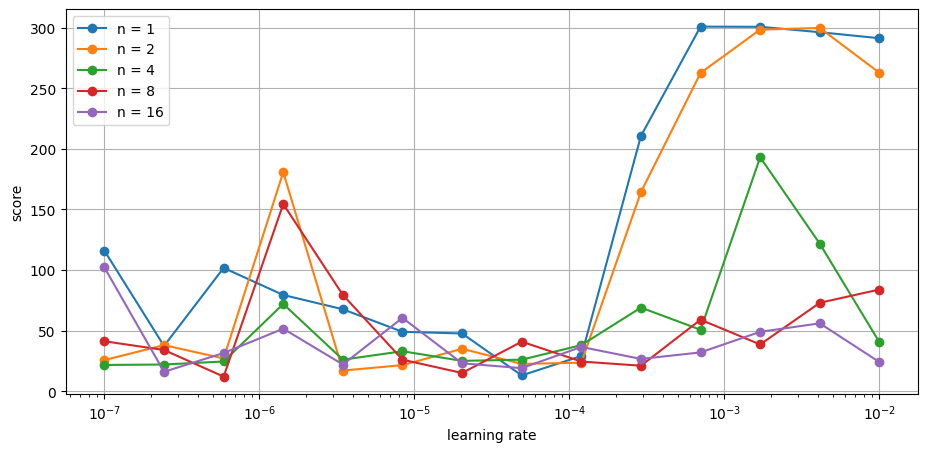

In [14]:
plt.figure(figsize=(11, 5))
for j, n in enumerate(n_list): 
    plt.plot(lr_list, final_results[:, j], '-o', label=f"n = {str(n)}")
plt.xlabel("learning rate")
plt.ylabel("score")
plt.xscale("log")
plt.grid()
plt.legend()
plt.show()

Each data point depicted in the above graph represents the most favorable outcome obtained from a set of five distinct experiments conducted with identical $n$ and learning-rate values. Ideally, under optimal conditions, the resulting graph would resemble the figure 10.4 illustrated in Chapter 10.2 of [1]. However, besides the variation of the learning-rate, no other hyperparameters were optimized. Moreover, we restricted each episode to a duration of 200 steps, which is typically insufficient for the network to gather sufficient transitions for learning. Nevertheless, intriguing qualitative behavior is observed with certain learning-rate intervals yielding better performance for different values of $n$.

## Conclusion

We have implemented a modified version of the on-policy Reinforcement Learning (RL) algorithm n-step SARSA. The algorithm employs an experience replay buffer and a neural network representation for the Q-function. The experience replay buffer operates by managing n-step transitions rather than the original 0-step transitions. We conclude by training the Q-network with batches of n-step transitions on the Cart-Pole Gymnasium environment. For a more lucid comprehension of the n-step SARSA algorithm, it is recommended to review the notebook encompassing the n-step SARSA tabular implementation, which precisely follows the pseudocode outlined in [1].

## References
- [1] Sutton & Barto - Reinforcement Learning An Introduction Second edition (2018)

## Contact
If you have any comments, corrections or questions about the material presented in the notebook, please do not hesitate to email me at elkabetz.roy@gmail.com